<center>

<h1>📚 Maestría en Inteligencia Artificial Aplicada – 3er Semestre</h1>

<h3>Asignatura: Procesamiento de Lenguaje Natural</h3>

<hr style="width:60%;">

<h2>👨‍🎓 Estudiantes</h2>
<ul style="list-style:none; padding:0; font-size:18px;">
    <li>Claudia Martínez</li>
    <li>Sebastián Murillas</li>
    <li>Mario J. Castellanos</li>
    <li>Enrique Manzano</li>
    <li>Octavio Guerra</li>
</ul>

<hr style="width:60%;">

<h3>📅 Fecha: Agosto 15, 2025</h3>

</center>


# Analisis de Sentimientos en reseñas de Hoteles hechas en Trip Advisor

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https:////colab.research.google.com/github/semurillas/NLP_MIAA_252/blob/main/Sesion%201/Practice/7-sentiment-analysis.ipynb)

Para esta práctica, decidimos realizar un análisis de sentimientos a partir de reseñas de hoteles publicadas en TripAdvisor. El objetivo fue clasificar cada reseña en uno de dos posibles valores: negativo (neg) o positivo (pos). Tomando como referencia el ejercicio base compartido por el profesor Luis Ferro, utilizamos el modelo de NLTK con Vader Lexicon para evaluar y comparar el nivel de precisión de las predicciones que genera y entrega frente a las valoraciones reales presentes en el conjunto de datos analizado.

### Referencias
* [Natural Language Processing in Action](https://www.manning.com/books/natural-language-processing-in-action)

## 1. Chequeo de ambiente y Manejo de "Warnings"

En esta primer código verificamos si el ambiente de Trabajo es "Google Colab" e ignorar algun mensaje de "Warning" que suceda a lo resto del Notebook.

In [ ]:
import importlib.metadata    # Importación del modulo de metadata de la libreria importlib
import warnings               # Importación de la libreria warnings

# Uso de la libreria importlib.metadata para obtener los paquetes
# instalados en el Notebook
installed_packages = [dist.metadata['Name'].lower() for dist in importlib.metadata.Distribution.discover()]

# Chequeando que Google Colab este entre los paquetes instalados
# para confirmar si es el ambiente de trabajo usado.
IN_COLAB = 'google-colab' in installed_packages

# Ignorar algun Warning generado durante la ejecución del Notebook
warnings.filterwarnings('ignore')

## 2. Cargue de Librerías

Confirmando a traves de validación que estamos trabajando en "Google Colab", instalamos las librerías requeridas en el Notebook usando: **pip install -r** y el Archivo de Requerimientos desde el GitHub del Proyecto:

https://raw.githubusercontent.com/semurillas/NLP_MIAA_252/refs/heads/main/requirements_7.txt

###Notas:
- Agregamos al URL el texto: **$(date +%s)**, para garantizar que se use la última versión del Archivo requerimients_7.txt en el Notebook.

In [ ]:
!test '{IN_COLAB}' = 'True' && pip install -r "https://raw.githubusercontent.com/semurillas/NLP_MIAA_252/refs/heads/main/requirements_7.txt?nocache=$(date +%s)"

## 3. Cargando el Dataset para someter a Analisis de Sentimiento

El grupo escogió un Dataset que contiene los comentarios (Reviews) y Calificaciones (Ratings) que dieron clientes de Hoteles en la aplicación Trip Advisor. Este dataset esta disponible en: https://www.kaggle.com/code/heeraldedhia/airbnb-reviews-sentiment-analysis-and-prediction/notebook

Este Dataset lo usaremos para realizar el proceso de Análisis de Sentimiento (Sentiment-Analysis) en los siguientes pasos desarrollados en el Notebook.

In [ ]:
import pandas as pd      # Libreria requerida para manejo de DataFrames
import requests          # Libreria requerida para hacer HTTP requests

# Paso 1: Descargar el documento del Proyecto de GitHub en la ruta especificada.
csv_url = "https://raw.githubusercontent.com/semurillas/NLP_MIAA_252/refs/heads/Practice-1/Sesion%201/datasets/tripadvisor_hotel_reviews.csv"
csv_file_path = "reviewers.csv"

response = requests.get(csv_url)
with open(csv_file_path, "wb") as f:
    f.write(response.content)

print(f"Archivo descargado como: {csv_file_path} \n")     # Confirmación de que el archivo seleccionado haya sido descargado exitosamente.

# Carga de los datos del archivo csv al dataframe reviews
reviews = pd.read_csv(csv_file_path)

Archivo descargado como: reviewers.csv 



## 4. Chequeo y Limpieza del contenido del Dataset Cargado

Para confirmar que el Dataset reviews fue cargado exitosamente y realizar operaciones de limpieza del contenido, realizaremos las siguientes actividades:

- Listar los diez (10) primeros registros del Dataset reviews.
- Obtener el numero de registros cargados en el Dataset reviews.
- Chequeo de registros con valores nulos o vacios en el Dataset reviews.

### 4.1. Listar los diez (10) primeros registros del Dataset reviews

In [ ]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


### 4.2. Cantidad de registros cargados en el Dataset reviews

In [ ]:
# Obtener la cantidad de registros en el Dataset
nro_registros = reviews.shape[0]

# Imprimir el Numero de Registros cargados en el Dataset
print("Se cargaron: ", nro_registros, "en el Dataset reviews")

Se cargaron:  20491 en el Dataset reviews


### Comenario sobre Punto 4.2.
Los registros cargados coinciden con los 20491 registros mencionados en la información del Dataset en Kaggle: https://www.kaggle.com/code/heeraldedhia/airbnb-reviews-sentiment-analysis-and-prediction/notebook.

### 4.3. Chequeo de Registros con Valores Nulos y Vacios en el Dataset

- Chequeo de valores Nulos en el Dataset
- Chequeo de valores vacios en el Dataset

#### 4.3.1. Chequeo de Valores Nulos en el Dataset

In [ ]:
reviews.isna().sum()

,0
Review,0
Rating,0


#### 4.3.2. Chequeo de Valores vacios en el Dataset

In [ ]:
# If que valida si hay valores vacios en los dos campos: Reviews & Rating
if reviews[reviews.Review == ''].index.size > 0 or reviews[reviews.Rating == ''].index.size > 0 :
    print('Se encontraron valores vacios en el Dataset')
    print(reviews[reviews.Review == ''].index)
    print(reviews[reviews.Rating == ''].index)
else:
    print('No se encontraron valores vacios en el Dataset')

No se encontraron valores vacios en el Dataset


### Comentario sobre Punto 4.3.
No se encontraron valores Nulos, ni valores Vacios en el Dataset reviews, por lo que no se hace necesario hacer alguna limpieza o borrado en el mismo.


### 5.Conteo de la Cantidad de Registros por Valores de Rating en el Dataset

Obtengamos el conteo de registros en el Dataset agrupados por los diferentes valores de Rating en el mismo.

In [ ]:
reviews.Rating.value_counts()

,count
Rating,
5,9054
4,6039
3,2184
2,1793
1,1421


### Comentario sobre Punto 5.

Podemos ver que hay mas registros con Rating 5 (9054), que registros con Rating 1 y 2 (1793 ´+ 1421 = 3214)

### **Análisis**

Este conjunto de datos presenta cierto desbalance, ya que existen significativamente más registros con una calificación de 5 (positivos) que con calificaciones de 1 o 2 (negativos). Este desequilibrio podría afectar el análisis, pues el modelo podría desarrollar una tendencia a predecir resultados positivos en lugar de negativos.

Adicional,  con base en la información disponible en Kaggle sobre este conjunto de datos, puede ser recomendable eliminar las calificaciones de 3 y 4, ya que se consideran neutras.
**¿Por qué?**  Nuestro objetivo es enfocar el análisis de sentimiento únicamente en dos posibles valores de sentimiento: Positivo (pos) y Negativo (neg).

### 6. Borrado de los Registros con Rating3 and 4 en el Dataset Reviews

La razón es que de acuerdo a la información explicativa del Dataset en Kaggle, estos valores de Rating, son considerados "Neutrales". En nuestro proceso, estamos considerando trabajar con valores Positivos y Negativos. Esto significa que los valores de Rating 1,2 y 5 son los recomendados y adecuados para el proceso.

In [ ]:
# Borrado de los Registros con Rating 3 en el Dataset reviews
reviews = reviews[reviews.Rating != 3]

# Borrado de los Registros con Rating 4 en el Dataset reviews
reviews = reviews[reviews.Rating != 4]

# Chequeo de la cantidad de Registros despues de remover los Registros con valores
# de Rating 3 y 4.
print("La cantidad de Registros del Dataset reviews es: ", reviews.shape[0])

La cantidad de Registros del Dataset reviews es:  12268


### Comentario sobre el Punto 6.

Es evidente la disminución en la cantidad de Registros. Antes de eliminar los Registros con los valores de Rating 3 y 4, teníamos: 20,491 Registros.

Despues de la eliminación: 12,268 Registros. De aqui en adelante trabajaremos con esta cantidad de Registros.

### 7. Uso de NTLK y VADER LEXICON

Ahora vamos a importar la Librería de NLTK para ser usada para el Procesamiento de Lenguaje Natural y usaremos el Léxico VADER_LEXICON que es un léxico de sentimientos.
Usaremos ambos para obtener una predicción Positiva (pos) y Negativa (Neg) sobre los reviews hechos por los clientes y que tenemos en el Dataset **reviews**

In [ ]:
import nltk         # Importación de la Librería NLTK

# Descarga del Lexico de Sentimientos VADER_LEXICON para NLTK
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 8. Agregando una nueva Columna "Scores" al Dataset reviews

Se agrega una nueva columna denominada "Scores". El **valor** que se pone a esta columna para cada registro es obtenido por el analisis de sentimiento que se hace con **NLTK** y el Lexico **VADER_LEXICON**

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer ## Importación del Módulo Sentiment de la Librería NLTK

# Creación de una Instancia del Objeto SentimentIntensityAnalizer()
sid = SentimentIntensityAnalyzer()

# Creación de la caracteristica "Scores" con el valor obtenido de aplicar SentimentIntensityAnalyzer
# al campo "Review" en el Dataset "Review"
reviews['scores'] = reviews.Review.apply(lambda r: sid.polarity_scores(r))

# Revisemos la nueva columna creada en los cinco (5) primeros registros del Dataset
reviews.head()

,Review,Rating,scores
1,ok nothing special charge diamond member hilto...,2,"{'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'com..."
3,"unique, great stay, wonderful time hotel monac...",5,"{'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'com..."
4,"great stay great stay, went seahawk game aweso...",5,"{'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'co..."
5,love monaco staff husband stayed hotel crazy w...,5,"{'neg': 0.084, 'neu': 0.651, 'pos': 0.265, 'co..."
6,"cozy stay rainy city, husband spent 7 nights m...",5,"{'neg': 0.026, 'neu': 0.609, 'pos': 0.364, 'co..."


### 9.  Generemos una Predicción usando la Columna "Scores"
Usando los Score que resultaron del SentimentIntensityAnalysis hecho en el paso ocho (8), hacemos dos (2) cosas:
- Creamos una nueva columna llamada **"compound"** al Dataset reviews, que resulta de extraer de la columna "Scores" el valor respectivo.
- Con el valor en la columna **"compound"**, evaluamos si es un valor mayor a cero, lo cual lo hace Positivo (pos) o si es menor que cero, lo que lo hace Negativo. Los resultados los ponemos en una nueva columna llamada **"prediction"** en el Dataset reviews.

#### 9.1 Creación de la Columna "compound" al Dataset reviews

In [ ]:
# Creamos una nueva columna "compound" y
# extraemos el valor de compound de los valores en la columna "Scores"
# del Dataset reviews
reviews['compound'] = reviews.scores.apply(lambda s: s['compound'])

# Chequeemos que en los cinco (5) primeros registros aparece la nueva columna
# "compound"
reviews.head()

,Review,Rating,scores,compound
1,ok nothing special charge diamond member hilto...,2,"{'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'com...",0.9787
3,"unique, great stay, wonderful time hotel monac...",5,"{'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'com...",0.9912
4,"great stay great stay, went seahawk game aweso...",5,"{'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'co...",0.9797
5,love monaco staff husband stayed hotel crazy w...,5,"{'neg': 0.084, 'neu': 0.651, 'pos': 0.265, 'co...",0.9870
6,"cozy stay rainy city, husband spent 7 nights m...",5,"{'neg': 0.026, 'neu': 0.609, 'pos': 0.364, 'co...",0.9925


#### 9.2.. Adición de la nueva columna "prediction" al Dataset.

In [ ]:
# Creación de la nueva columna "prediccion"
# usando valor de pos si el valor de compound es >0 o
# neg si el valor de compound es <0.
reviews['prediction'] = reviews['compound'].apply(lambda c: 'pos' if c >0 else 'neg')


# Veamos el valor de la nueva columna "prediction" en los cinco (5) primeros
# registros del Dataset reviews.
reviews.head()

,Review,Rating,scores,compound,prediction
1,ok nothing special charge diamond member hilto...,2,"{'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'com...",0.9787,pos
3,"unique, great stay, wonderful time hotel monac...",5,"{'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'com...",0.9912,pos
4,"great stay great stay, went seahawk game aweso...",5,"{'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'co...",0.9797,pos
5,love monaco staff husband stayed hotel crazy w...,5,"{'neg': 0.084, 'neu': 0.651, 'pos': 0.265, 'co...",0.9870,pos
6,"cozy stay rainy city, husband spent 7 nights m...",5,"{'neg': 0.026, 'neu': 0.609, 'pos': 0.364, 'co...",0.9925,pos


### 10. Cantidad de Registros con Valores pos y neg en la columna "prediction" del Dataset reviews.

Veamos cuantos registros del Dataset reviews quedaron con el valor pos o el valor neg en la columna "prediction"

In [ ]:
reviews.prediction.value_counts()

,count
prediction,
pos,10876
neg,1392


### 11. Generación nueva columna "sentiment_label" en el Dataset

Ya tenemos las predicciones que se hicieron con SentimentIntensityAnalyzer con NTLK y el Lexico de sentimientos VADER_LEXICON almacenadas en la columna "prediction" del Dataset reviews.

Ahora usando el valor de la columna "Rating" en el Dataset, agregamos una nueva columna llamada "sentiment_label". El valor en esta nueva columna lo obtendremos considerando: pos si el valor de Rating es 5 y neg si el valor de Rating es 1 o 2.

Esto lo hacemos para luego generar Métricas de Análisis y comparar que tanto acerto NTLK y VADER_LEXICON vs Ratings.

In [ ]:
# Creación de la nueva columna "sentiment_label" en el Dataset reviews y
# Mapeo de los Valores de Rating a Positivo (pos) con Rating 5 y Negativo (neg).
reviews['sentiment_label'] = reviews['Rating'].apply(lambda rating: 'neg' if rating <= 2 else 'pos')

# Muestra de los cinco (5) primeros registros del Dataset reviews con la nueva columna "sentiment_label"
reviews.head()

,Review,Rating,scores,compound,prediction,sentiment_label
1,ok nothing special charge diamond member hilto...,2,"{'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'com...",0.9787,pos,neg
3,"unique, great stay, wonderful time hotel monac...",5,"{'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'com...",0.9912,pos,pos
4,"great stay great stay, went seahawk game aweso...",5,"{'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'co...",0.9797,pos,pos
5,love monaco staff husband stayed hotel crazy w...,5,"{'neg': 0.084, 'neu': 0.651, 'pos': 0.265, 'co...",0.9870,pos,pos
6,"cozy stay rainy city, husband spent 7 nights m...",5,"{'neg': 0.026, 'neu': 0.609, 'pos': 0.364, 'co...",0.9925,pos,pos


### 12. Generación de Metricas para Análisis

Vamos a generar usando los valores en la columna "prediction" y "sentiment_label" del Dataset Reviews las siguientes metricas:

- Exactitud (Accuracy)
- Matriz de Confusión.
- Reporte de Clasificación.

Estas métricas las obtendremos al comparar los valores pos y neg de ambas columnas: prediction y sentiment_label, y comparar cuales son iguales y diferentes. En otras palabras, significa comparar el valor de pos y neg que se obtuvo de la columna "Review" para cada registro con NTLK y VADER_LEXICON (Predicción) vs el valor de pos y neg asignado con el valor de Rating (Real).

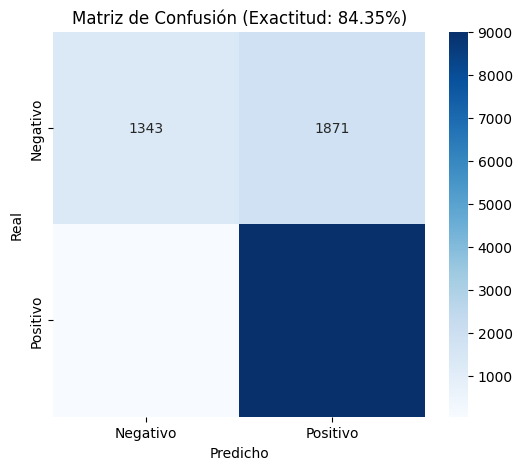

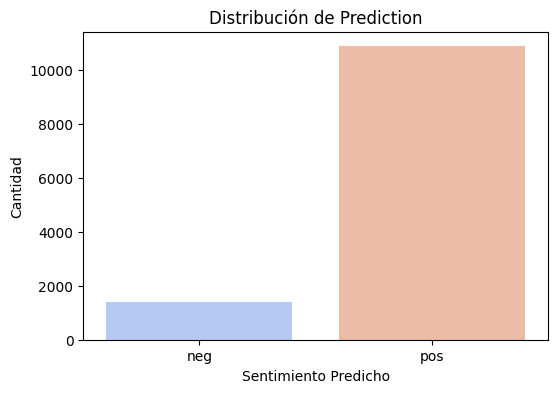

Reporte de Clasificación:

              precision    recall  f1-score   support

         neg       0.96      0.42      0.58      3214
         pos       0.83      0.99      0.90      9054

    accuracy                           0.84     12268
   macro avg       0.90      0.71      0.74     12268
weighted avg       0.86      0.84      0.82     12268



In [ ]:
import matplotlib.pyplot as plt         # Importación de la Libreria matplotlib para realizar gráficas.
import seaborn as sns                   # Importación de la Libreria seaborn para visualización de datos.

# Importación de los módulos accuracy_score, confussion_matrix y classification_report para obtener las métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Carga de los Valore Reales (pos y neg) desde la columna "sentiment_label"
y_true = reviews["sentiment_label"].values

# Carga de los valores Predichos (pos y neg) desde la columna "prediction"
y_pred = reviews["prediction"].values

# Obtención de las Métricas
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, output_dict=True)

# ---- 1. Gráfica de la Matriz de Confusión ----
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negativo", "Positivo"],
            yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión (Exactitud: {accuracy:.2%})")
plt.show()

# ---- 2. Gráfico de Barras para Distribución de Clases ----
plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred, order=["neg", "pos"], palette="coolwarm")
plt.xlabel("Sentimiento Predicho")
plt.ylabel("Cantidad")
plt.title("Distribución de Prediction")
plt.show()

# ---- 3. Impresión del Reporte de Clasificación ----
print("Reporte de Clasificación:\n")
print(classification_report(y_true, y_pred))


## CONCLUSIONES

Según las métricas obtenidas, el Modelo NTLK con el Lexico de Sentimientos VADER_LEXICON:

- Ofrece una exactitud del 84.35%, es decir que de 100 reviews del Dataset acerto 84.35. Es un buen numero, sin embargo, hay que tener en cuenta que desde el principio revelamos el desbalanceo que existe entre los "Reviews" positivos y negativos. En otras palabras, es un buen valor, pero se hace necesario comparar con las otras métricas obtenidas: Matriz de Confusión y Reporte de Clasificación, dado lo desbalanceado en la data.

- Podemos notar por la Matriz de Confusión que NTLK y VADER_LEXICON, fueron muy acertados en predecir "Reviews" con Positivo (pos), lo hizo , pero nada bueno en los Negativos (neg), tuvo 1871 Falsos Positivos y 1343 Verdaderos Negativos, lo cual es un valor mucho menor. Esto significa que con NTLK y VADER_LEXICON al haber usado este dataset, puede entregar mejores predicciones positivas que negativas.

- Para Mejorar este Modelo con el Dataset usado, se hace necesario "balancear", es decir, agregar al Dataset mas datos con Ratings y Reviews Negativos, de manera que le permita al modelo mejorar la predicción de lo negativo.

- Conclusion final: El uso de NTLK y VADER_LEXICON, es muy bueno prediciendo "Reviews" Positivos, pero regular en acertar "Reviews" Negativos.
